# Graph Neural Networks

Setting up a message-passing graph neural network, from scratch, in a simple manner.
(without asking for efficiency)

Eventually, we try it on a physics-inspired task: finding the ground state energy of the Schroedinger equation on a graph (otherwise, most of the code is general).

Quick recap:

A message passing graph NN layer computes a message m for each edge i<--j in the graph. 

This message m depends on the current value x (a vector) of the source node j and on the value x of the target node i, as well as on the edge value e_ij (which here is assumed fixed). Thus, we have:

m_ij = M(x_i,x_j,e_ij)

where M is a neural network taking three inputs, the message network.

Now all the messages going to the same i are summed up:

m_i = sum_j m_ij

The result is inserted into an update network U, together with the current value x_i of the node. This produces the new value of the node i:

x_i(new) = U(x_i,m_i)

That is all. 

Now the next layer can be applied, where the networks M and U have changed. Note that the dimensionality of the node value vectors x can change from layer to layer, and that also the message (a vector) can have a different dimensionality. This is all defined while setting up the U and M networks for each layer.

To run a graph NN, one needs to feed in a graph, i.e. the initial node values, the edge values, and the connectivity structure (which node i receives from which node j).

Florian Marquardt 2021, MIT License

In [1]:
import tensorflow as tf
import tensorflow.keras as tfk
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple # useful for the graph tuple

plt.rcParams['figure.facecolor'] = 'beige'
global_debug_print=False

## Graph Network Class

In [2]:
# a graph data structure (see the help for GraphNN.apply)
# this is just a tuple of three lists, but we turned it into
# a 'namedtuple', so the entries can be accessed by name.
Graph=namedtuple('Graph',['node_values','edge_values','receives_from'])

class GraphNN:
    """
    A message passing graph NN layer computes a message m for each edge i<--j in the graph. 

    This message m depends on the current value x (a vector) of the source node j and on the value x of the target node i, as well as on the edge value e_ij (which here is assumed fixed). Thus, we have:

    m_ij = M(x_i,x_j,e_ij)

    where M is a neural network taking three inputs, the message network.

    Now all the messages going to the same i are summed up:

    m_i = sum_j m_ij

    The result is inserted into an update network U, together with the current value x_i of the node. This produces the new value of the node i:

    x_i(new) = U(x_i,m_i)

    That is all. 

    Now the next layer can be applied, where the networks M and U have changed. Note that the dimensionality of the node value vectors x can change from layer to layer, and that also the message (a vector) can have a different dimensionality. This is all defined while setting up the U and M networks for each layer.

    To run a graph NN, one needs to feed in a graph, i.e. the initial node values, the edge values, and the connectivity structure (which node i receives from which node j).
    """
    def __init__(self, message_networks, update_networks, 
                 final_pooling_network, final_pooling_fn):
        """
        Initialize a graph neural network, by giving a list of
        message networks and a list of update networks (the output
        dimension of each message network defines one input into the
        update network of the same layer, and the update network's output
        defines the node dimension of the result, being fed into the
        next message network etc.)
        """
        self.message_networks=message_networks
        self.update_networks=update_networks
        self.trainable_variables=[]
        for net in message_networks+update_networks:
            self.trainable_variables.extend(net.trainable_variables)
        self.final_pooling_network=final_pooling_network
        self.final_pooling_fn=final_pooling_fn
        self.optimizer=tf.optimizers.Adam(learning_rate=0.0002)
        
    def apply(self, graph):
        """
        Apply the graph neural network to a graph.
        
        The graph is a tuple with entries (node_values,edge_values,receives_from).
        
        node_values: The feature vectors on the node, to be processed by the
        NN. This is of shape [num_nodes, dim_node_features]. 
        Examples: Atom type in a molecule, or density in a distribution on a graph.
        
        edge_values: The feature vectors for the edges, to be used by the NN
        (but not to be processed in this version of a graph NN). 
        It is of shape [num_edges, dim_edge_features].
        Examples: Bond length for a molecule, distance for a traffic network graph,
        coupling strength for a quantum problem.
        
        receives_from is a list of length num_nodes, where each entry
        is another list of tuples, of the form (idx_node,idx_edge), where each tuple indicates
        that there is an edge (with index idx_edge) pointing from the source node
        idx_node to the present 'target' node.
        
            Example of the format:
            receives_from=[[(1,0)], [(0,1),(2,3)], [(1,2)]]
            This means (each sub-list refers to another target node, here 0,1,2):
                [(1,0)]: target node 0 receives from node 1 (edge labeled 0)
                [(0,1),(2,3)]: node 1 receives from node 0 (edge 1) and also from node 2 (edge 3)
                [(1,2)]: node 2 receives from node 1 (edge 2)
        """
        node_values,edge_values,receives_from=graph
        
        # go through all layers, obtain for each of them
        # the message network and the update network:
        for message_network, update_network in zip(self.message_networks,self.update_networks):
            # this will become the list of the accumulated messages (one for each node):
            messages=[]
            # go through all nodes ('targets'), fetching the list of source nodes for each of them:
            for node_target_idx,sources in enumerate(receives_from):
                cumulative_message = None # set accumulated message to 'None' first
                # go through all source nodes for this particular target node:
                for node_source_idx,edge_idx in sources:
                    # calculate the message, given the source and target node values
                    # and given the edge value of the corresponding edge.
                    # we insert a fake length-1 'batch dimension' so the network
                    # can run like a usual network:
                    
                    if global_debug_print:
                        print(f"before msg: node_values dim {node_values.shape} edge dim {edge_values.shape}")
                        
                    message = message_network([node_values[node_target_idx][None,:],
                                                node_values[node_source_idx][None,:],
                                                edge_values[edge_idx][None,:]])
                    
                    if global_debug_print:
                        print(f"target {node_target_idx} source {node_source_idx} edge {edge_idx}; \
message dim: {message.shape}")
                    
                    if cumulative_message is None:
                        cumulative_message = message
                    else:
                        cumulative_message += message
                if cumulative_message is None:
                    # must create a zero message of the right form
                    messages.append(tf.zeros([1,message_network.layers[-1].units]))
                else:
                    messages.append(cumulative_message)
            # we now make things more efficient by taking all the messages
            # and stacking them inside one big tensor of shape [num_nodes,node_message_dim]:
            messages_tensor=tf.concat(messages,axis=0)
            
            if global_debug_print:
                print(f"messages combined dim: {messages_tensor.shape}")
                print(f"node_values dim: {node_values.shape}")
            
            # now apply the update network to all of this at once, together with the node_values:
            node_values=update_network([node_values,messages_tensor])
        
            if global_debug_print:
                print(f"node_values after update dim: {node_values.shape}") 
        return node_values

In [3]:
def create_message_network(dim_node_values,
                           dim_edge_values,layers):
    """
    Create a message network M([target,source,edge]). This network processes source and target neuron
    values, as well as an edge value, to produce a message going from source to target.
    
    dim_node_values: The number of neurons encoding a node value.
    dim_edge_values: Number of neurons encoding an edge value.
    layers: list of neuron numbers and activation functions for the network (which
        is created as a fully connected network). Example: [(10,"relu"),(5,"linear")],
        which will mean the dim_message (the output) is 5.
    
    Returns: a keras network.
    
    The returned keras network has three inputs, to be passed as a list:
        [input_target_node_value,input_source_node_value,input_edge_value]
    Here input_target_node_value is a tensor of dimension [batchsize,dim_node_values],
    likewise input_source_node_value. input_edge_value has shape [batchsize,dim_edge_values].
    """
    input_target_node_value=tfk.layers.Input(shape=(dim_node_values,))
    input_source_node_value=tfk.layers.Input(shape=(dim_node_values,))
    input_edge_value=tfk.layers.Input(shape=(dim_edge_values,))
    x=tf.concat([input_target_node_value,input_source_node_value,input_edge_value],axis=-1)
    for num_neurons,activation in layers:
        x=tfk.layers.Dense(num_neurons,activation=activation)(x)
    return tfk.models.Model(inputs=[input_target_node_value,input_source_node_value,input_edge_value],
                           outputs=x)

def create_update_network(dim_message,dim_node_values_input,layers):
    """
    Create an update network U([node_value,message]).
    
    dim_message: The dimension of the message being passed (must be compatible with
            the output of the message_network that is used to generate the messages).
    dim_node_values_input: The number of neurons encoding any node value before the update.
    
    layers: list of (num_neurons,activation) for each layer. See create_message_network.
    
    Returns: an update network.
    
    This takes as input a list [node_value,message] and outputs the updated node_value,
    which may have a different dimension, according to the num_neurons of the last layer.
    """
    input_node_value=tfk.layers.Input(shape=(dim_node_values_input,))
    input_message=tfk.layers.Input(shape=(dim_message,))
    x=tf.concat([input_node_value,input_message],axis=-1)
    for num_neurons,activation in layers:
        x=tfk.layers.Dense(num_neurons,activation=activation)(x)
    return tfk.models.Model(inputs=[input_node_value,input_message],
                           outputs=x)

## Simple Tests: Setting up a graph neural network

In [4]:
# create message and update networks

# number of dimensions of the node values in each layer (including input and output):
dim_nodes_layers=[1,3,1]
# shapes of message networks (hidden and output layer neuron numbers, and activation functions)
msg_nets_layers=[ [(10,"relu"),(5,"linear")],
                 [(12,"tanh"),(2,"linear")] ]
# dimension of edge values
dim_edge_values=1

# now produce the list of message networks
message_networks=[create_message_network(dim_node_values=dim_nodes,
                            dim_edge_values=dim_edge_values, layers=layers) for dim_nodes,layers in
                 zip(dim_nodes_layers,msg_nets_layers)]

# shapes of update nets (output dimensions of each layer must match node value dimension
# of the next node layer, i.e. dim_nodes_layers[1] from above must match the output dim. of the
# first update net listed here)
update_nets_layers=[ [(11,"tanh"),(3,"linear")],
                     [(8,"tanh"),(1,"linear")]
                   ]

# create all update networks
update_networks=[create_update_network(dim_message=msg_layers[-1][0],
                                      dim_node_values_input=dim_nodes,
                                      layers=update_layers) for dim_nodes,msg_layers,update_layers in
                zip(dim_nodes_layers,msg_nets_layers,update_nets_layers)]

# produce a graph NN from all these networks
graphNN=GraphNN(message_networks=message_networks,
            update_networks=update_networks,
            final_pooling_network=None,
            final_pooling_fn=None )

In [5]:
# make a simple test graph by hand, just for testing
# this has 3 nodes and 4 edges 0<--1, 0<--2, 1<--2, 1<--1

graph=Graph(
       node_values=tf.constant(np.random.randn(3,dim_nodes_layers[0])),
       edge_values=tf.constant(np.random.randn(4,dim_edge_values)),
       receives_from=[[(1,0),(2,1)],[(2,2),(1,3)],[]])


In [6]:
# now apply the graph NN on this graph
graph_out=graphNN.apply(graph)

In [7]:
graph_out

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.5956437 ],
       [0.29177904],
       [0.29254922]], dtype=float32)>

In [8]:
graph=Graph(
       node_values=np.full([3,dim_nodes_layers[0]],0.0),
       edge_values=np.full([4,dim_edge_values],1.0),
       receives_from=[[(1,0),(2,1)],[(2,2),(1,3)],[]])

# now apply the graph NN on this graph
graph_out=graphNN.apply(graph)

graph_out

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-0.6650176],
       [-0.6650176],
       [ 0.       ]], dtype=float32)>

## Example: Schroedinger equation on random graphs

### Random graph generation and plotting

In [9]:
# Routines for creating and plotting random graphs
                 
def graph_is_connected(num_nodes,connections):
    """
    Given the connections (list of lists [i,j] to indicate
    edges i--j): check whether the (bidirectional) graph is connected.
    """
    visited=[0]
    fully_explored=[False]*num_nodes
    while True: # will break if all nodes have been visited
        to_be_done=[v for v in visited if not fully_explored[v]] # all nodes to consider
        if len(to_be_done)==0:
            break # all nodes have been visited and fully explored
        for node_source in to_be_done:
            # check all connections from this node to others
            connections_from_source=[c[1] for c in connections if c[0]==node_source and c[1] not in visited] + \
                [c[0] for c in connections if c[1]==node_source and c[0] not in visited]
            # mark all connected nodes as visited
            if len(connections_from_source)>0:
                for node in connections_from_source:
                    if node not in visited:
                        visited.append(node)
            fully_explored[node_source]=True
    return len(visited)==num_nodes # have we reached everything? then the graph is connected
    
def produce_graph_receives_from(num_nodes,connections):
    """
    Turns a graph, given by num_nodes and connections list,
    into the 'receives_from' format that is needed for the graph NN.
    Here, we assume the graph is bidirectional. Every connection goes both ways.
    
    Returns:
    
    receives_from, num_nodes, num_edges
    
    See GraphNN.apply for the format of the receives_from
    num_edges is the number of edges in the graph
    """
    idx_edge=0
    receives_from=[[] for _ in range(num_nodes)]
    for link in connections:
        receives_from[link[0]].append( (link[1],idx_edge) )
        receives_from[link[1]].append( (link[0],idx_edge) ) # goes both ways!
        idx_edge+=1
    return receives_from, num_nodes, idx_edge

def check_graph(connections):
    """
    Check whether there a duplicate links.
    """
    for idx,link in enumerate(connections):
        a,b=link
        for other_idx,other_link in enumerate(connections):
            if other_idx != idx:
                if (other_link[0]==a and other_link[1]==b) or (other_link[0]==a and other_link[1]==b):
                    print(f"Duplicate link: old {idx},{link}, new {other_idx} {other_link}")


def create_lattice_graph(N,prob):
    """
    Create a graph from a N x N square lattice where we choose to place
    horizontal and vertical links between nearest neighbors with
    probability prob.
    
    Returns:
    connections,node_idx,positions
    
    Where connections is a list of connections (each link only appearing
    once; understood to be bidirectional), node_idx is a NxN array indicating
    the nodes index of every site (-1 if a site is unconnected and not part of
    the graph), and positions is a list of the position (jx,jy) of each node:
    positions[node_idx] belongs to that node.
    
    len(positions) is the number of nodes.
    
    You can use these values to feed into produce_graph_receives_from to obtain
    the kind of link representation that is needed later for the graphs processed
    by the GraphNN.
    """
    # random links on a square lattice
    # vertical[jx,jy]==True if vertical link (jx,jy)->(jx,jy+1)
    vertical=np.random.uniform(size=[N,N-1])<prob 
    # horizontal[jx,jy]==True if horizontal link (jx,jy)->(jx+1,jy)
    horizontal=np.random.uniform(size=[N-1,N])<prob

    node_idx=np.full([N,N],-1,dtype='int')

    # mark all nodes that have at least one connection and number them:
    node=0
    positions=[]
    for jx in range(N):
        for jy in range(N):
            # check whether we have any connections at all from this vertex
            if (jy<N-1 and vertical[jx,jy]) or (jy>0 and vertical[jx,jy-1]) \
            or (jx<N-1 and horizontal[jx,jy]) or (jx>0 and horizontal[jx-1,jy]):
                node_idx[jx,jy]=node
                positions.append((jx,jy))
                node+=1

    # now create connections list
    # every link appears only once (so [i,j] is enough, there is no [j,i])
    connections=[]
    for jx in range(N):
        for jy in range(N):
            if (jy<N-1 and vertical[jx,jy]):
                connections.append([node_idx[jx,jy],node_idx[jx,jy+1]])
            if (jx<N-1 and horizontal[jx,jy]):
                connections.append([node_idx[jx,jy],node_idx[jx+1,jy]])
    return connections,node_idx,positions

def create_random_connected_simple_lattice_graph(N,prob):
    go_on=True
    while go_on: # go on until we get a connected graph
        connections,node_idx,positions=create_lattice_graph(N=N,prob=prob)
        num_nodes=len(positions)
        receives_from,num_nodes,num_edges=produce_graph_receives_from(num_nodes,connections)
        if graph_is_connected(num_nodes,connections):
            go_on=False
            graph=Graph(node_values=np.full([num_nodes,1],0.0),
                            edge_values=-np.full([num_edges,1],1.0),
                            receives_from=receives_from)
        else:
            go_on=True
    return graph,positions

def plot_lattice_graph(graph,N,positions,node_values,edge_values,
               linewidth_scale=2.0,
               color_positive_edge="cornflowerblue",
               color_negative_edge="red",
               radius=0.2,ax=None):
    """
    Plot a graph.
    
    graph: The graph. See GraphNN.apply for format.
    N: The size of the graph (for the visualization) is NxN.
    positions: A list of the (x,y) position of every node.
    node_values: The values at the nodes, of size num_nodes.
                Positive values are plotted in blue, negative in
                red, more intense means higher absolute value.
    edge_values: Values of edges (links). Positive blue, negative
                red. Absolute value represented as linewidth.
    linewidth_scale: The maximum linewidth for the edges.
    color_positive_edge: color used for edges with positive value.
    color_negative_edge: correspondingly
    radius: Radius used for the nodes.
    ax:  A matplotlib axis object, into which to draw. If None, just
         make a single plot (as with plt).
    """
    if ax is None:
        ax=plt.gca()
    _,_,receives_from=graph
    num_nodes=len(node_values)

    max_edge_values=np.amax(np.abs(edge_values))
    for target_idx,links in enumerate(receives_from):
        for source_idx,edge in links:
            ax.plot([positions[source_idx][0],positions[target_idx][0]],
                    [positions[source_idx][1],positions[target_idx][1]],
                    linewidth=linewidth_scale*np.abs(edge_values[edge])/max_edge_values,
                   color=color_positive_edge if edge_values[edge]>0 else color_negative_edge)
    max_value=np.amax(np.abs(node_values))
    for node_idx,value in enumerate(node_values):
        scaled_value=np.abs(value)/max_value
        ax.add_patch( plt.Circle((positions[node_idx][0],positions[node_idx][1]),radius,
                                 facecolor=(1.0-scaled_value,1.0-scaled_value,1.0-0.5*scaled_value**2) if value>0 else
                                         (1.0-0.5*scaled_value**2,1.0-scaled_value,1.0-scaled_value),
                               edgecolor='black', zorder=10) )
    ax.set_xlim(-2*radius,2*radius+N-1)
    ax.set_ylim(-2*radius,2*radius+N-1)
    ax.axis('off')
    ax.set_aspect('equal')

### Simple tests of random lattice graphs

disconnected
disconnected
disconnected


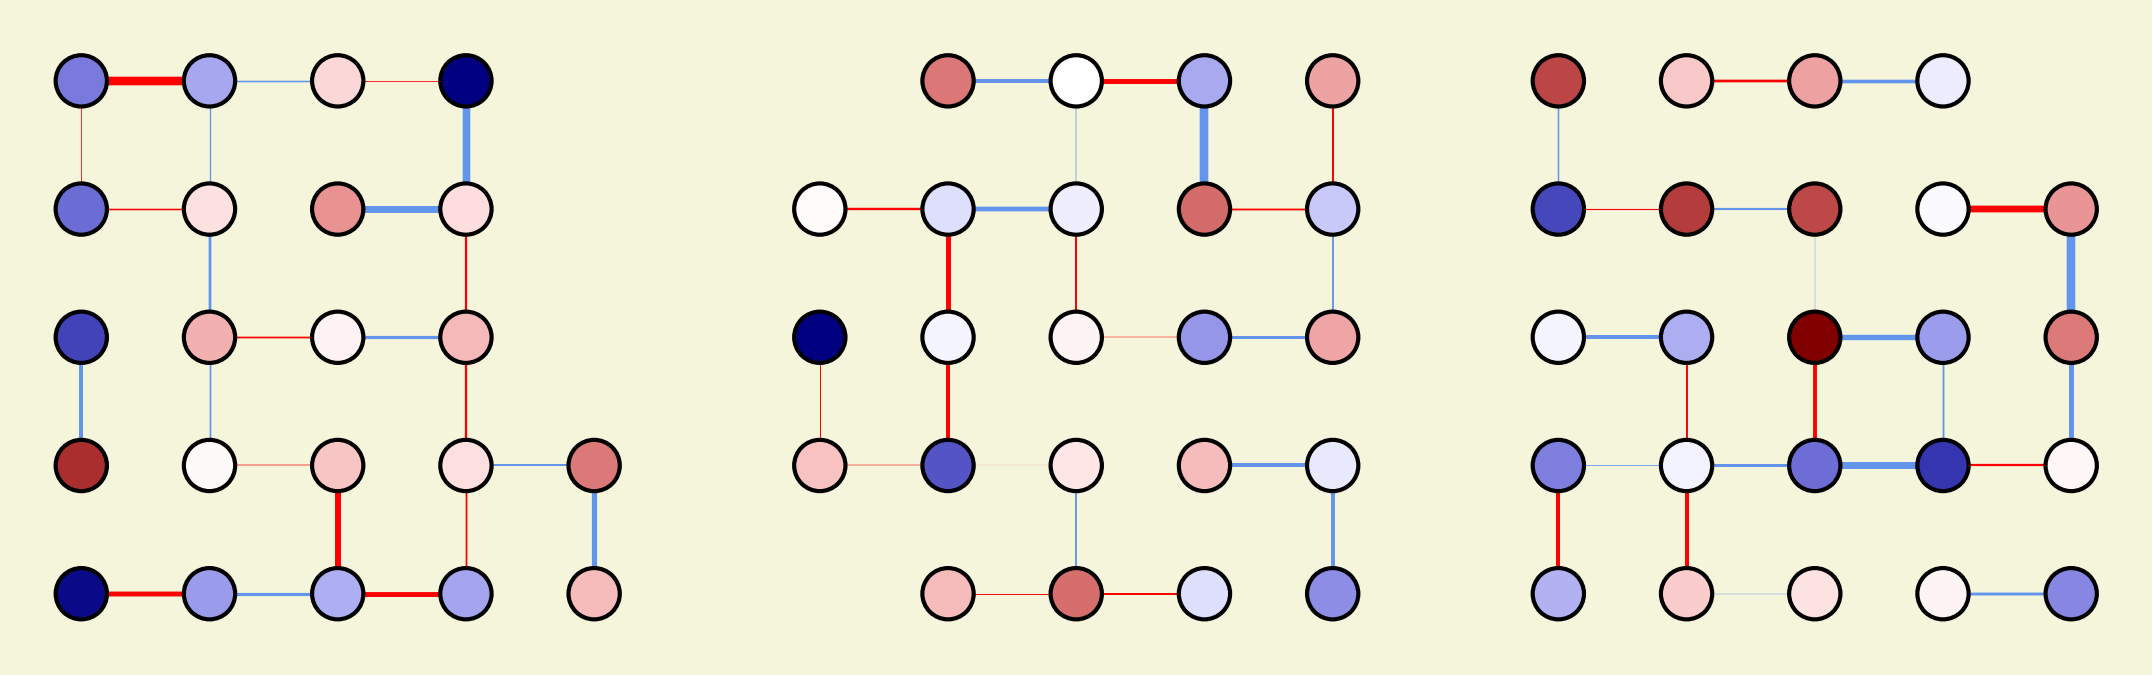

In [10]:
fig,ax=plt.subplots(ncols=3,dpi=300,figsize=(9,3))

N=5
for ax_entry in ax:
    connections,node_idx,positions=create_lattice_graph(N=N,prob=0.6)
    num_nodes=len(positions)
    receives_from,num_nodes,num_edges=produce_graph_receives_from(num_nodes,connections)
    scale_node_values=1.0
    scale_edge_values=1.0
    dim_node_values=1
    dim_edge_values=1
    if graph_is_connected(num_nodes,connections):
        print("connected")
    else:
        print("disconnected")
    graph=Graph(node_values=scale_node_values*np.random.randn(num_nodes,dim_node_values),
                    edge_values=scale_edge_values*np.random.randn(num_edges,dim_edge_values),
                    receives_from=receives_from)
    plot_lattice_graph(graph,N,positions,graph.node_values[:,0],graph.edge_values[:,0],ax=ax_entry)

### Test: Solve Schroedinger equation on graph

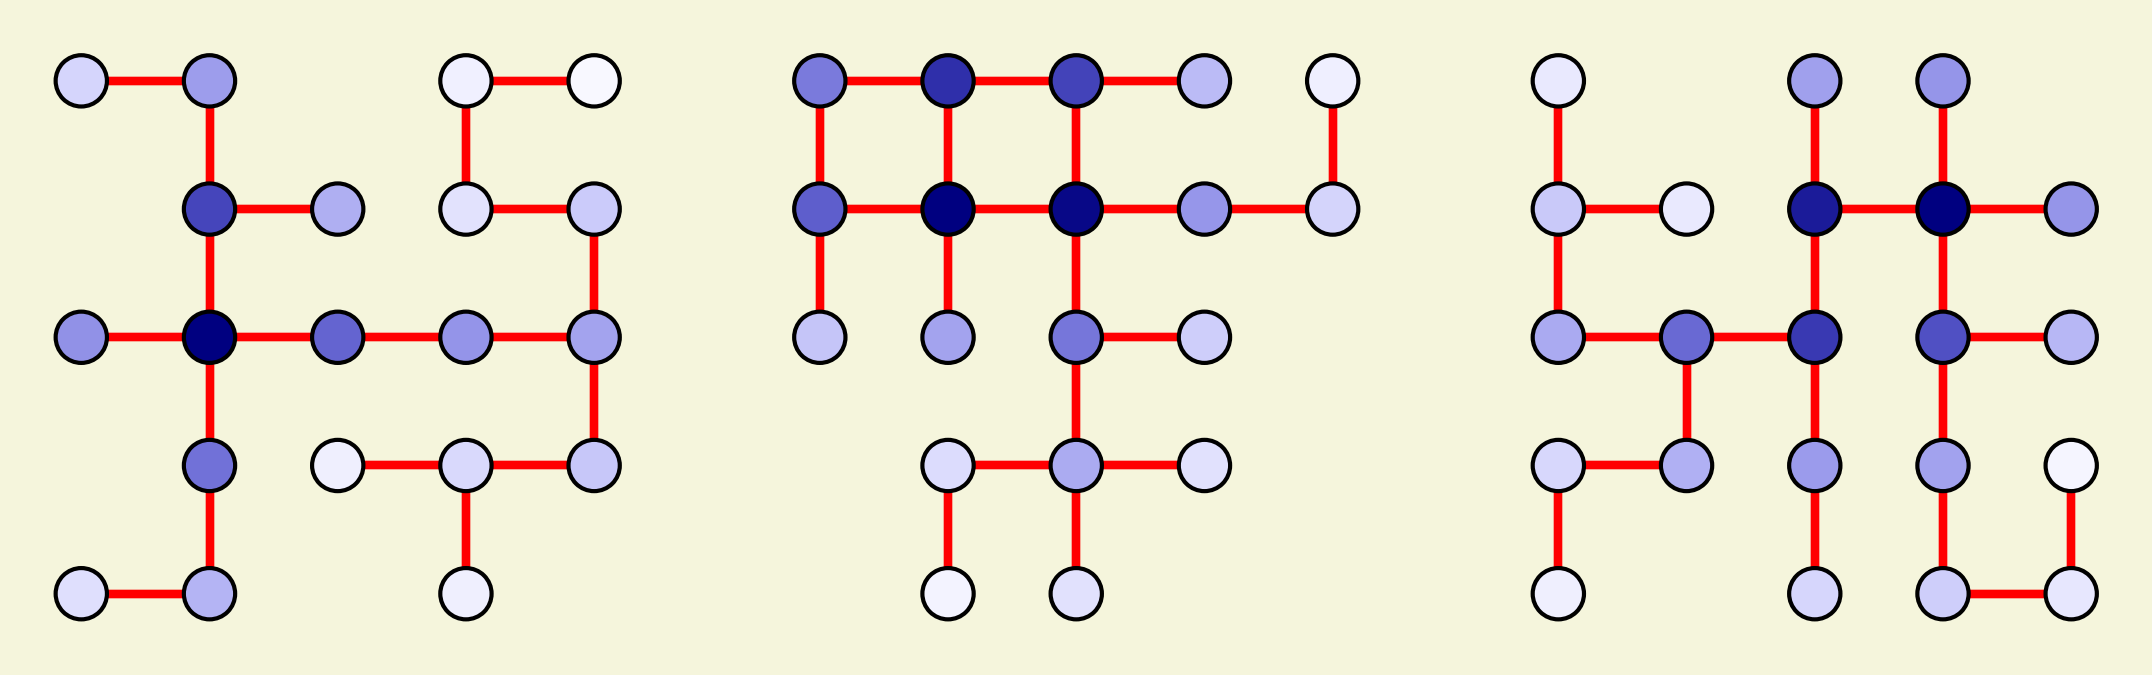

In [11]:
fig,ax=plt.subplots(ncols=3,dpi=300,figsize=(9,3))

N=5
prob=0.4
for ax_entry in ax:
    # get random graph
    graph,positions=create_random_connected_simple_lattice_graph(N=N,prob=prob)
    # solve SEQ
    num_nodes=len(positions)
    H=np.zeros([num_nodes,num_nodes])
    for source_node,links in enumerate(graph.receives_from):
        for target_node,edge_idx in links:
            H[target_node,source_node]=graph.edge_values[edge_idx,0]
    evals,evecs=np.linalg.eigh(H)
    Psi=evecs[:,0]
    # plot ground state solution on graph
    plot_lattice_graph(graph,N,positions,np.abs(Psi),graph.edge_values[:,0],ax=ax_entry)

### Get samples (random graph and solution of Schroedinger equation)

In [12]:
def get_sample(N,prob):
    """
    Produce graph on NxN lattice with probability prob for links,
    and also solve the Schroedinger equation on that graph.
    
    Returns:
    graph,positions,Psi
    
    graph: see graphNN.apply for structure
    positions: list of node positions, to be used with plot_lattice_graph
    Psi: ground state wavefunction (positive, real)
    """
    # get random graph
    graph,positions=create_random_connected_simple_lattice_graph(N=N,prob=prob)
    # solve SEQ
    num_nodes=len(positions)
    H=np.zeros([num_nodes,num_nodes])
    for source_node,links in enumerate(graph.receives_from):
        for target_node,edge_idx in links:
            H[target_node,source_node]=graph.edge_values[edge_idx,0]
    evals,evecs=np.linalg.eigh(H)
    Psi=np.abs(evecs[:,0]) # ground state wave function is real and of homogeneous sign
    return graph,positions,Psi

def evaluate_and_plot_test_samples(graphNN,test_samples,N,ax):
    """
    Evaluate the graphNN on a set of test_samples and
    plot the results. N is the lattice size, ax is the list
    of subplots for plotting the results.
    """
    for idx,sample in enumerate(test_samples):
        graph,positions,Psi=sample
        Psi_NN=graphNN.apply(graph)[:,0].numpy()
        plot_lattice_graph(graph,N,positions,np.abs(Psi),graph.edge_values[:,0],ax=ax[2*idx])
        plot_lattice_graph(graph,N,positions,np.abs(Psi_NN),graph.edge_values[:,0],ax=ax[2*idx+1])


### First test: training

In [13]:
# create message and update networks

# number of dimensions of the node values in each layer (including input and output):
dim_nodes_layers=[1,3,1]
# shapes of message networks (hidden and output layer neuron numbers, and activation functions)
msg_nets_layers=[ [(10,"relu"),(5,"linear")],
                 [(12,"tanh"),(2,"linear")] ]
# dimension of edge values
dim_edge_values=1

# now produce the list of message networks
message_networks=[create_message_network(dim_node_values=dim_nodes,
                            dim_edge_values=dim_edge_values, layers=layers) for dim_nodes,layers in
                 zip(dim_nodes_layers,msg_nets_layers)]

# shapes of update nets (output dimensions of each layer must match node value dimension
# of the next node layer, i.e. dim_nodes_layers[1] from above must match the output dim. of the
# first update net listed here)
update_nets_layers=[ [(11,"tanh"),(3,"linear")],
                     [(8,"tanh"),(1,"linear")]
                   ]

# create all update networks
update_networks=[create_update_network(dim_message=msg_layers[-1][0],
                                      dim_node_values_input=dim_nodes,
                                      layers=update_layers) for dim_nodes,msg_layers,update_layers in
                zip(dim_nodes_layers,msg_nets_layers,update_nets_layers)]

# produce a graph NN from all these networks
graphNN=GraphNN(message_networks=message_networks,
            update_networks=update_networks,
            final_pooling_network=None,
            final_pooling_fn=None )

# list of losses for training
losses=[]


In [14]:
# create test samples
N=5
prob=0.4
test_samples=[get_sample(N=N,prob=prob) for _ in range(8)]

In [15]:
# train
num_training_steps=100

for train_step in range(num_training_steps):
    graph,positions,Psi=get_sample(N=N,prob=prob)
    with tf.GradientTape() as tape:
        Psi_NN=graphNN.apply(graph)[:,0] # output was shape (num_nodes,1)
        loss=tf.reduce_sum((Psi_NN-Psi)**2)
    grads=tape.gradient(loss,graphNN.trainable_variables)
    graphNN.optimizer.apply_gradients(zip(grads,graphNN.trainable_variables))
    losses.append(loss.numpy())
    print(f"Step {train_step} Loss {loss.numpy()}", end="    \r")

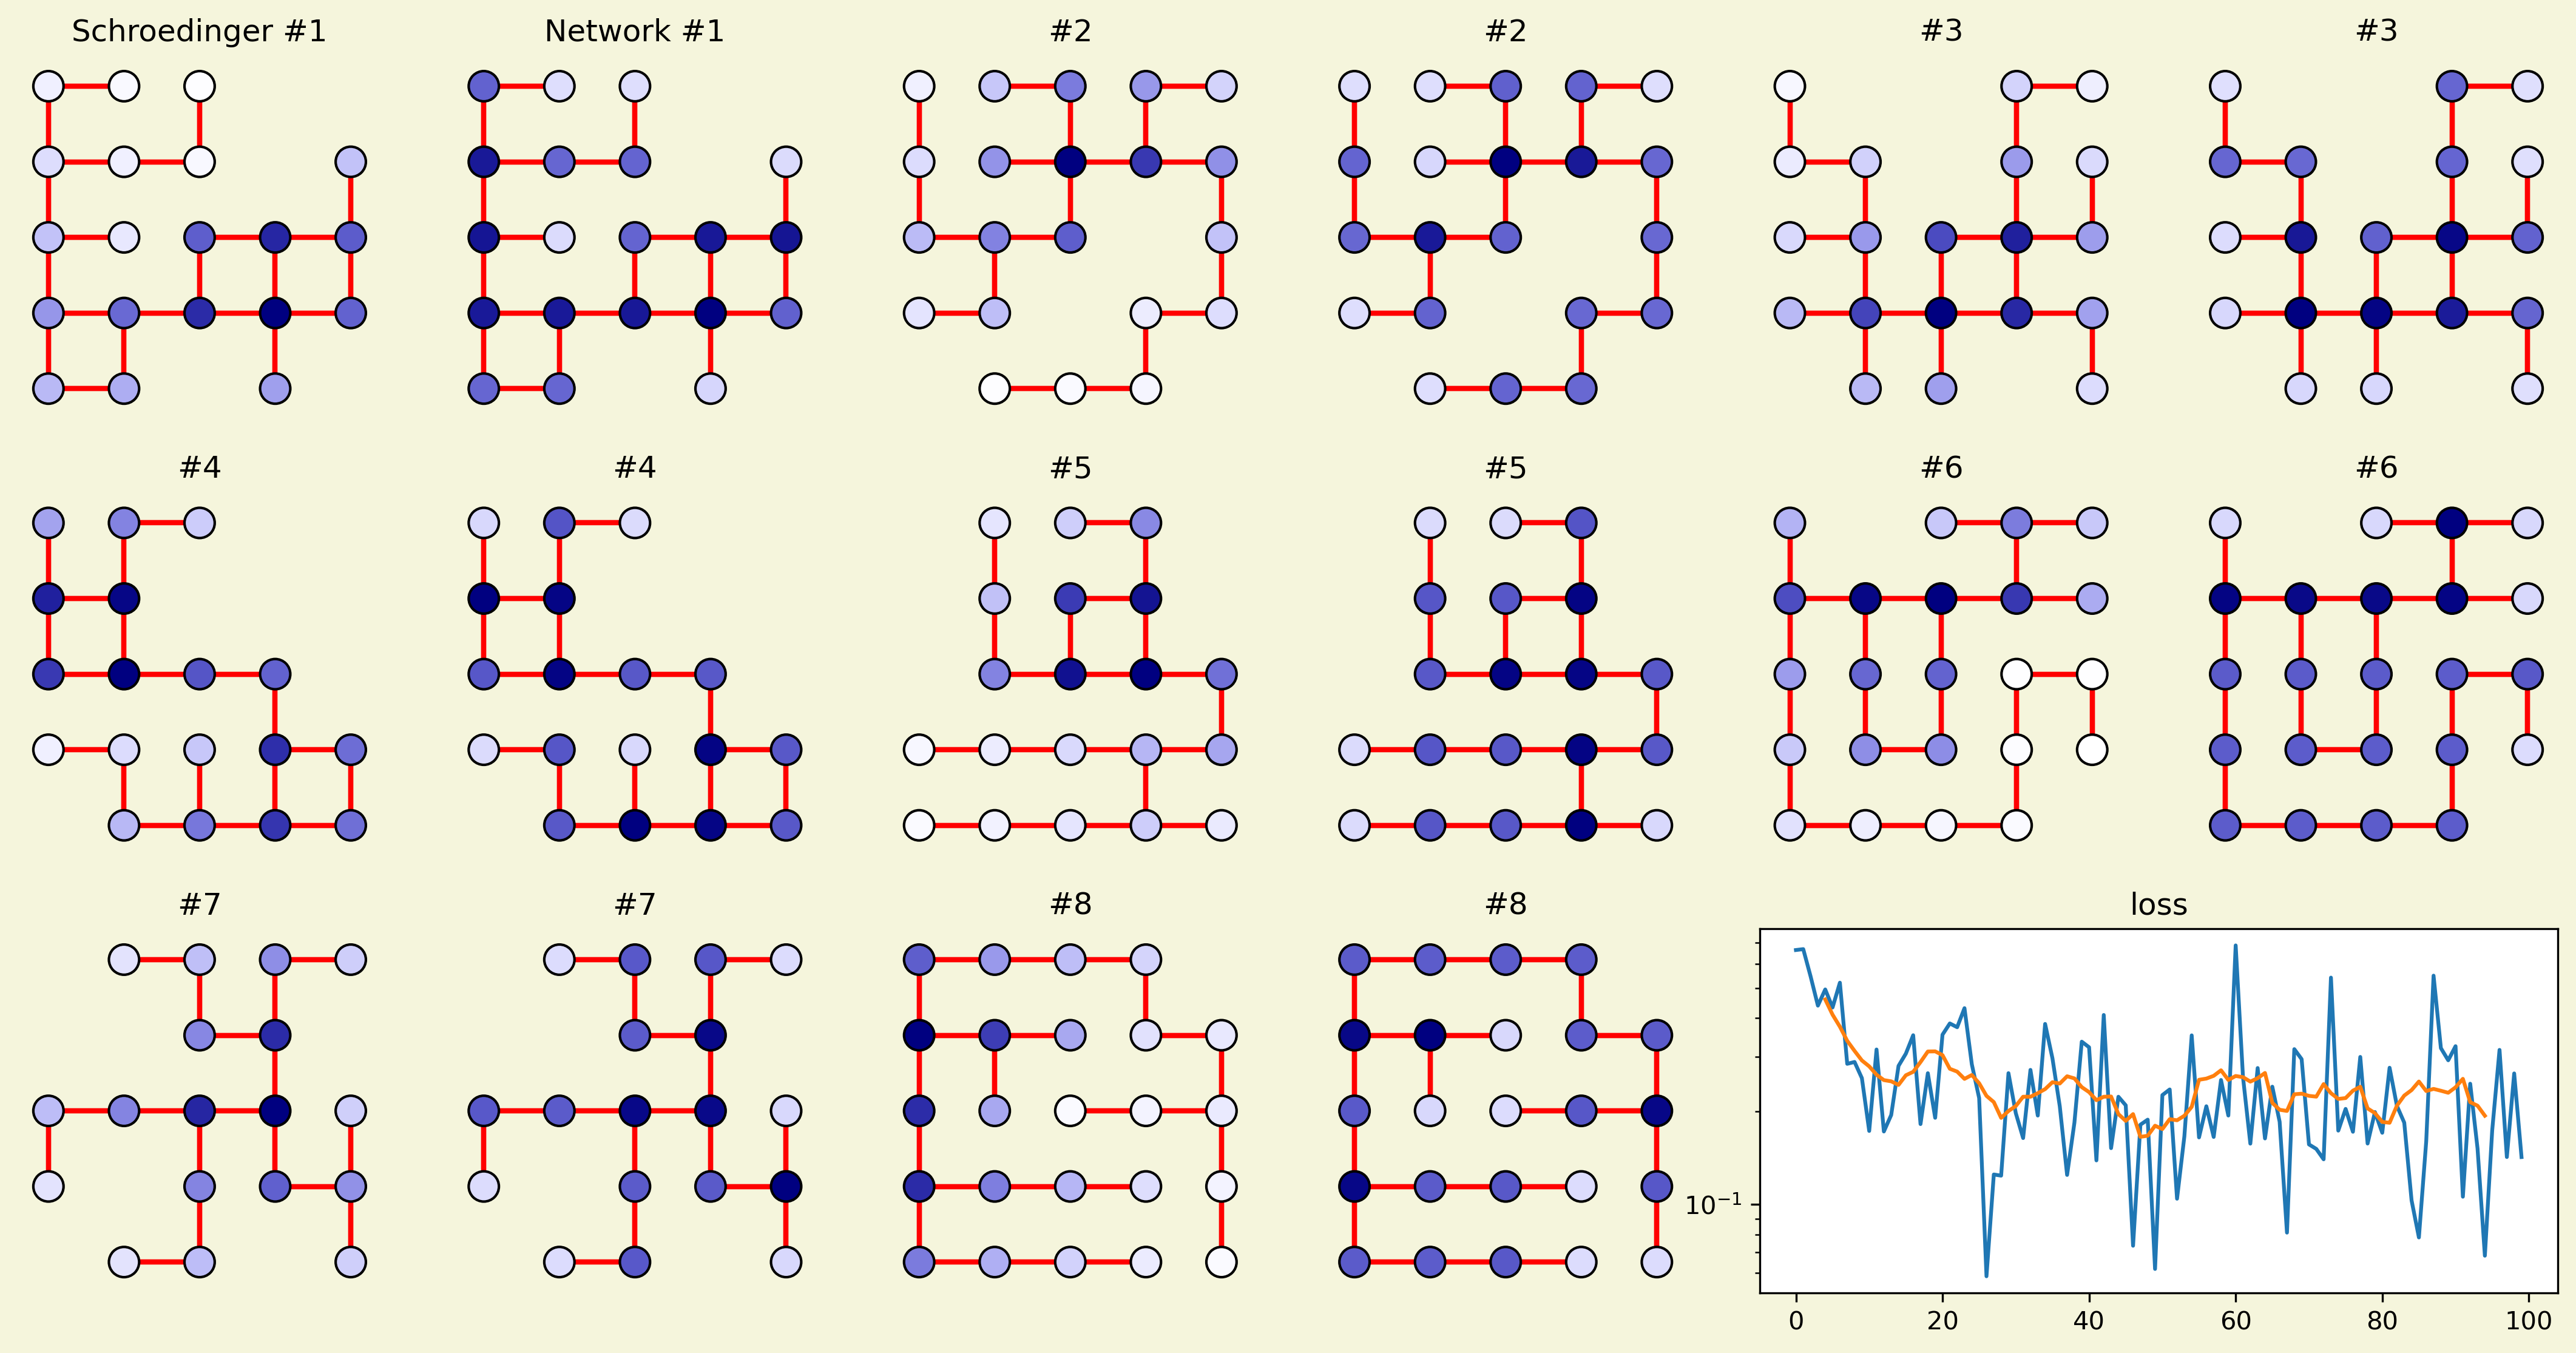

In [16]:
# plot the results

fig=plt.figure(figsize=(18,9),dpi=300)
mosaic="""
012345
6789AB
CDEFGG
"""
ax=fig.subplot_mosaic(mosaic)
ax=[ax[key] for key in ax]

evaluate_and_plot_test_samples(graphNN,test_samples,N=N,ax=ax)
ax[-1].semilogy(losses)
if len(losses)>=10:
    nsmooth=10
    ax[-1].semilogy(np.arange(nsmooth-1,len(losses))-nsmooth//2,
                 np.convolve(losses, np.ones((nsmooth,))/nsmooth, mode='valid'))
    ax[-1].set_title("loss")
    
ax[0].set_title("Schroedinger #1")
ax[1].set_title("Network #1")

for idx in range(1,8):
    text=f"#{idx+1}"
    ax[idx*2].set_title(text)
    ax[idx*2+1].set_title(text)

ax[0].set_facecolor("white")
ax[1].set_facecolor("white")
plt.show()


## Produce movie

In [26]:
# Movie code by FM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation,FFMpegFileWriter
from tqdm import trange

# this is what we use
def save_movie_with_setup(setup_func,update_func, nsteps, file, 
        fps=20, bitrate=1000,
        dpi_movie=300):
    """
    Save a movie into a file. This version of save_movie can call an
    arbitrary setup function, and may be useful for creating complicated subplot layouts.
    
    setup_func:  Called at beginning. Has to create figure and return fig,ax.
    update_func:  Called during the loop, with update_func(fig,ax,frame_number).
                This function simply needs to draw a fresh figure (e.g. imshow) inside fig,ax,
                without destroying fig,ax (i.e. you might use ax[k].clear() on each subplot ax[k],
                before drawing something into it).
    nsteps:     Number of frames
    file:       File name (e.g. ending in '.mp4')
    fps:        Frames per second (see matplotlib FuncAnimation or FFMpegFileWrite docs)
    bitrate:    Bitrate

    dpi_movie:  dpi for movie writer


    """
    # set up figure:
    fig, ax = setup_func()

    # now set up movie writer
    moviewriter = FFMpegFileWriter(fps=fps, bitrate=bitrate)
    # and run through frames:
    with moviewriter.saving(fig, file, dpi=dpi_movie):
        for j in trange(nsteps):
            update_func(fig,ax,j)
            moviewriter.grab_frame()


#### Movie: two-layer message and update networks

100%|█████████████████████████████████████████| 400/400 [16:47<00:00,  2.52s/it]


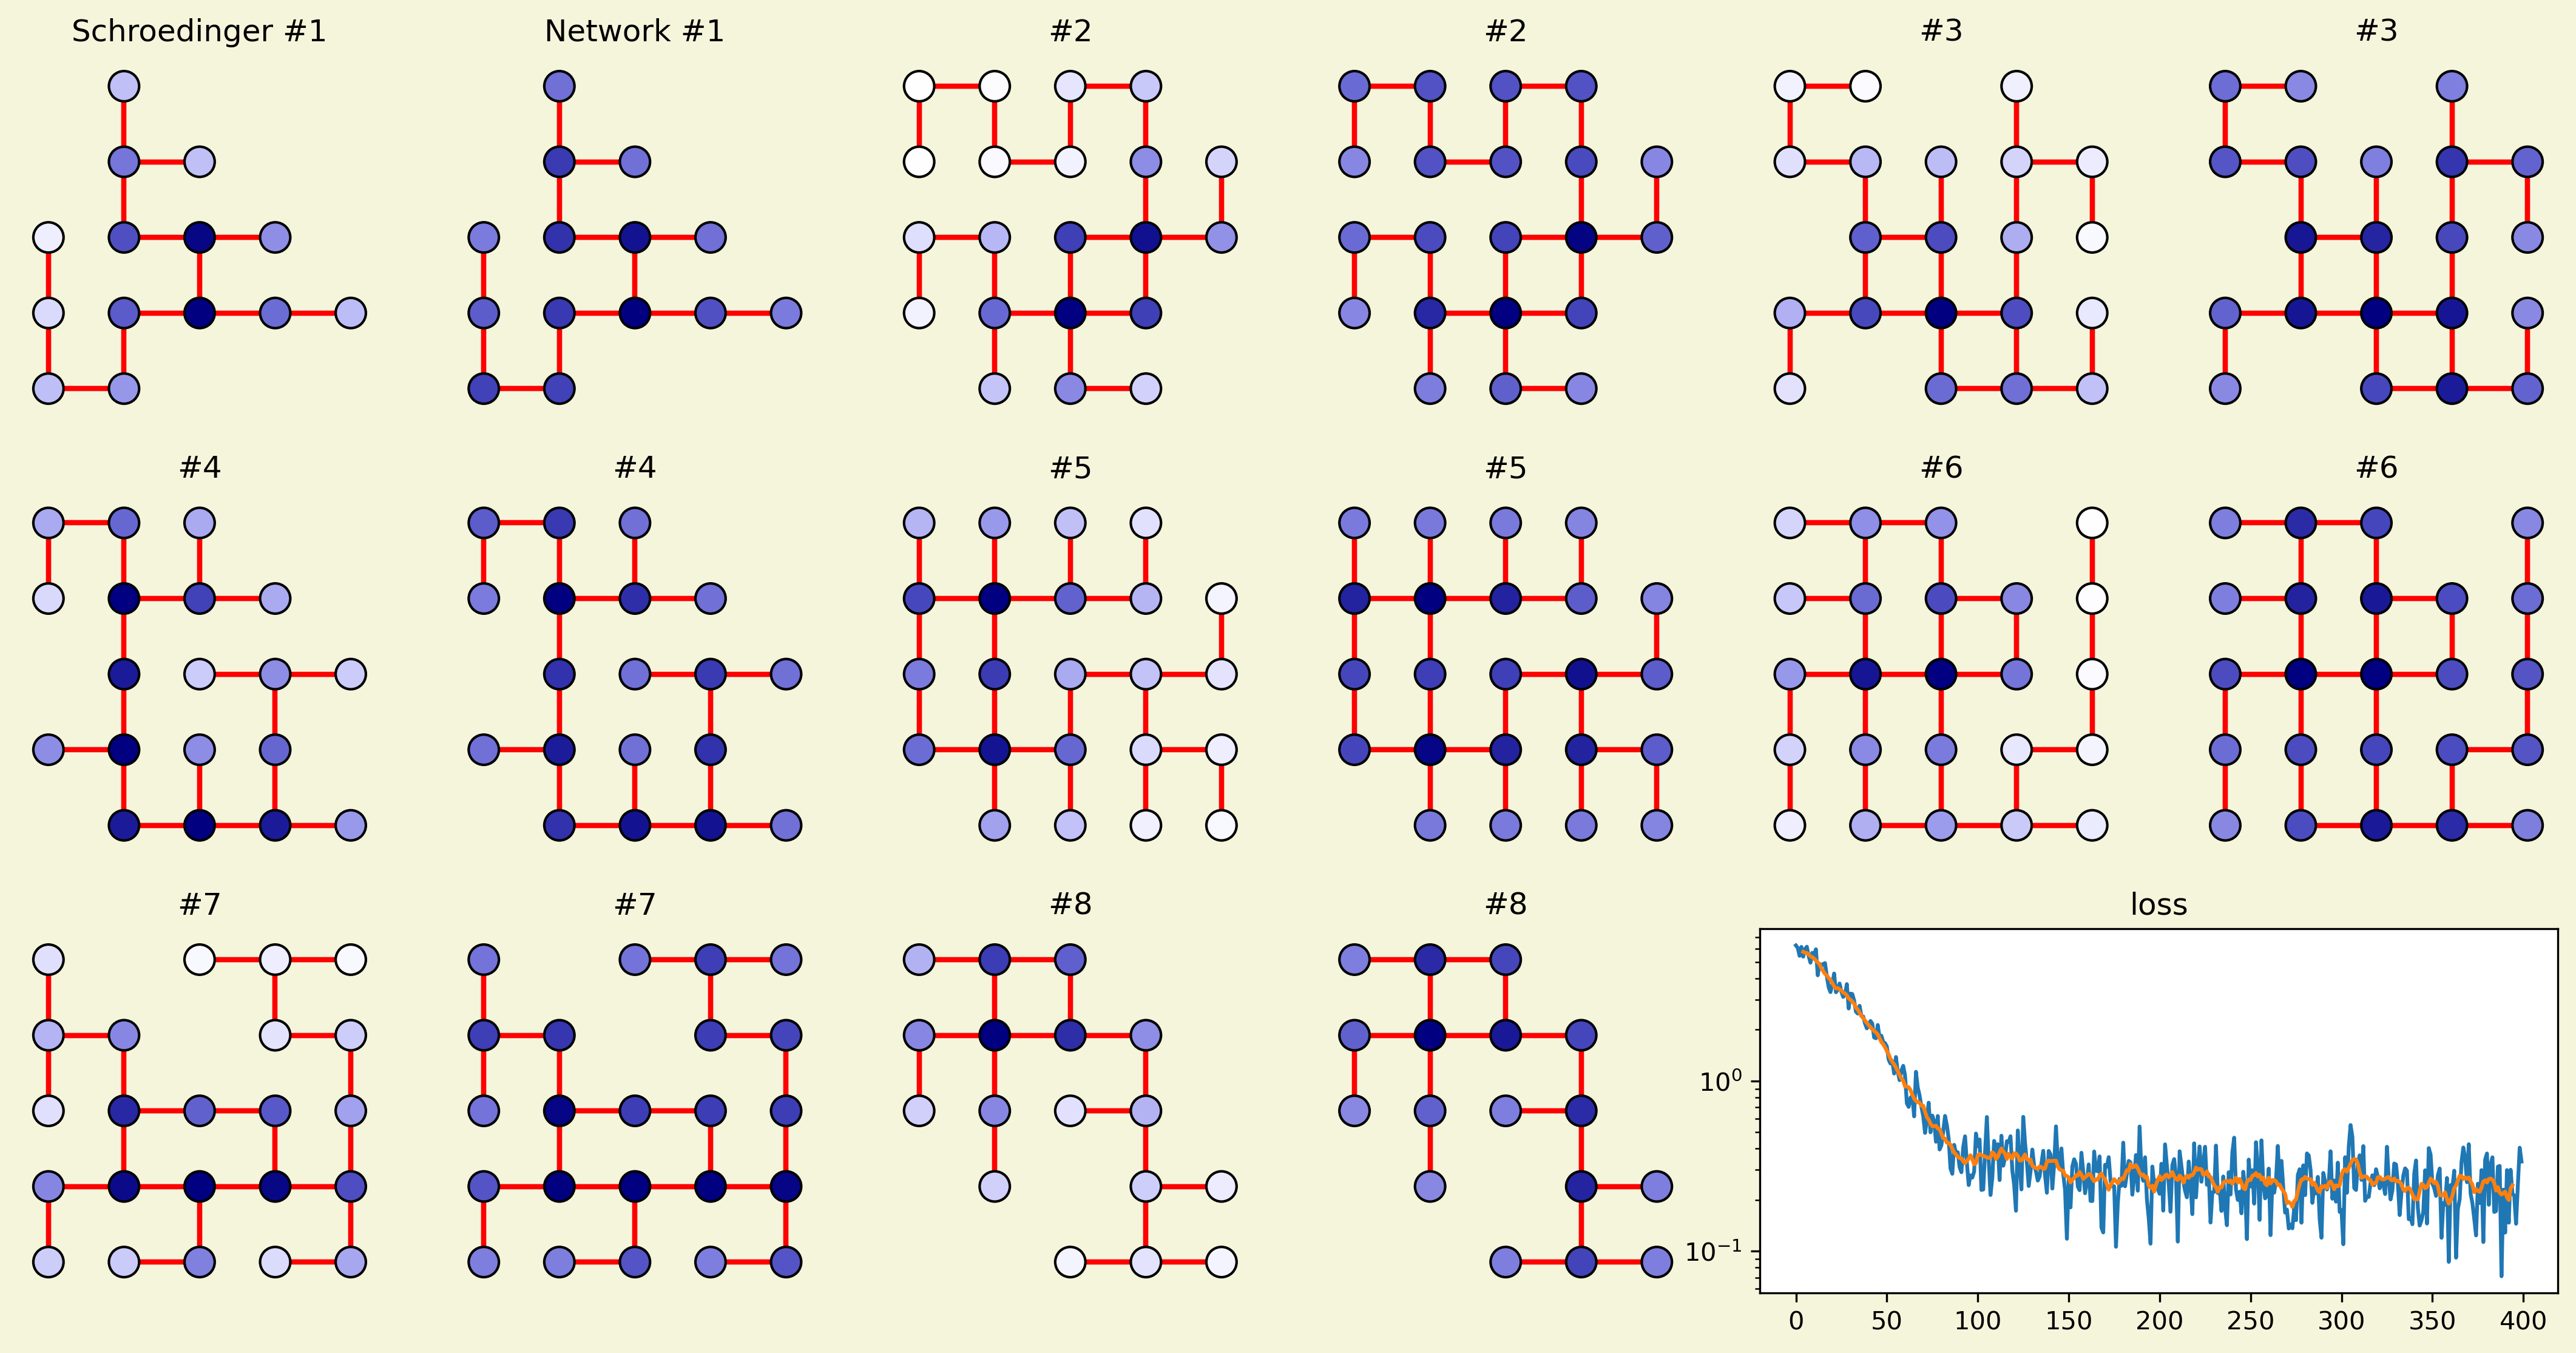

In [647]:
# create message and update networks

# number of dimensions of the node values in each layer (including input and output):
dim_nodes_layers=[1,3,1]
# shapes of message networks (hidden and output layer neuron numbers, and activation functions)
msg_nets_layers=[ [(10,"relu"),(5,"linear")],
                 [(12,"tanh"),(2,"linear")] ]
# dimension of edge values
dim_edge_values=1

# now produce the list of message networks
message_networks=[create_message_network(dim_node_values=dim_nodes,
                            dim_edge_values=dim_edge_values, layers=layers) for dim_nodes,layers in
                 zip(dim_nodes_layers,msg_nets_layers)]

# shapes of update nets (output dimensions of each layer must match node value dimension
# of the next node layer, i.e. dim_nodes_layers[1] from above must match the output dim. of the
# first update net listed here)
update_nets_layers=[ [(11,"tanh"),(3,"linear")],
                     [(8,"tanh"),(1,"linear")]
                   ]

# create all update networks
update_networks=[create_update_network(dim_message=msg_layers[-1][0],
                                      dim_node_values_input=dim_nodes,
                                      layers=update_layers) for dim_nodes,msg_layers,update_layers in
                zip(dim_nodes_layers,msg_nets_layers,update_nets_layers)]

# produce a graph NN from all these networks
graphNN=GraphNN(message_networks=message_networks,
            update_networks=update_networks,
            final_pooling_network=None,
            final_pooling_fn=None )

# list of losses for training
losses=[]

# prepare test samples
N=5
prob=0.4
test_samples=[get_sample(N=N,prob=prob) for _ in range(8)]

# prepare movie routines

def setup_figure():
    """
    Set up the figure for the animation.
    """
    fig=plt.figure(figsize=(18,9),dpi=300)
    mosaic="""
    012345
    6789AB
    CDEFGG
    """
    ax=fig.subplot_mosaic(mosaic)
    ax=[ax[key] for key in ax]
    return fig,ax

def anim_func(fig,ax,frame):
    """
    Will access N,prob,graphNN,test_samples, and add to losses !
    """
    # train
    graph,positions,Psi=get_sample(N=N,prob=prob)
    with tf.GradientTape() as tape:
        Psi_NN=graphNN.apply(graph)[:,0] # output was shape (num_nodes,1)
        loss=tf.reduce_sum((Psi_NN-Psi)**2)
    grads=tape.gradient(loss,graphNN.trainable_variables)
    graphNN.optimizer.apply_gradients(zip(grads,graphNN.trainable_variables))
    losses.append(loss.numpy())
    
    # plot
    for entry in ax:
        entry.clear()
    evaluate_and_plot_test_samples(graphNN,test_samples,N=N,ax=ax)
    ax[-1].semilogy(losses)
    if len(losses)>=10:
        nsmooth=10
        ax[-1].semilogy(np.arange(nsmooth-1,len(losses))-nsmooth//2,
                     np.convolve(losses, np.ones((nsmooth,))/nsmooth, mode='valid'))
        ax[-1].set_title("loss")

    ax[0].set_title("Schroedinger #1")
    ax[1].set_title("Network #1")

    for idx in range(1,8):
        text=f"#{idx+1}"
        ax[idx*2].set_title(text)
        ax[idx*2+1].set_title(text)

    ax[0].set_facecolor("white")
    ax[1].set_facecolor("white")

max_frames=400

save_movie_with_setup(setup_figure,anim_func, max_frames, "/tmp/GraphNN_movie.mp4", 
        fps=10, bitrate=2000,
        dpi_movie=300)

#### Movie: 6-layer message and update networks

100%|█████████████████████████████████████████| 400/400 [28:26<00:00,  4.27s/it]


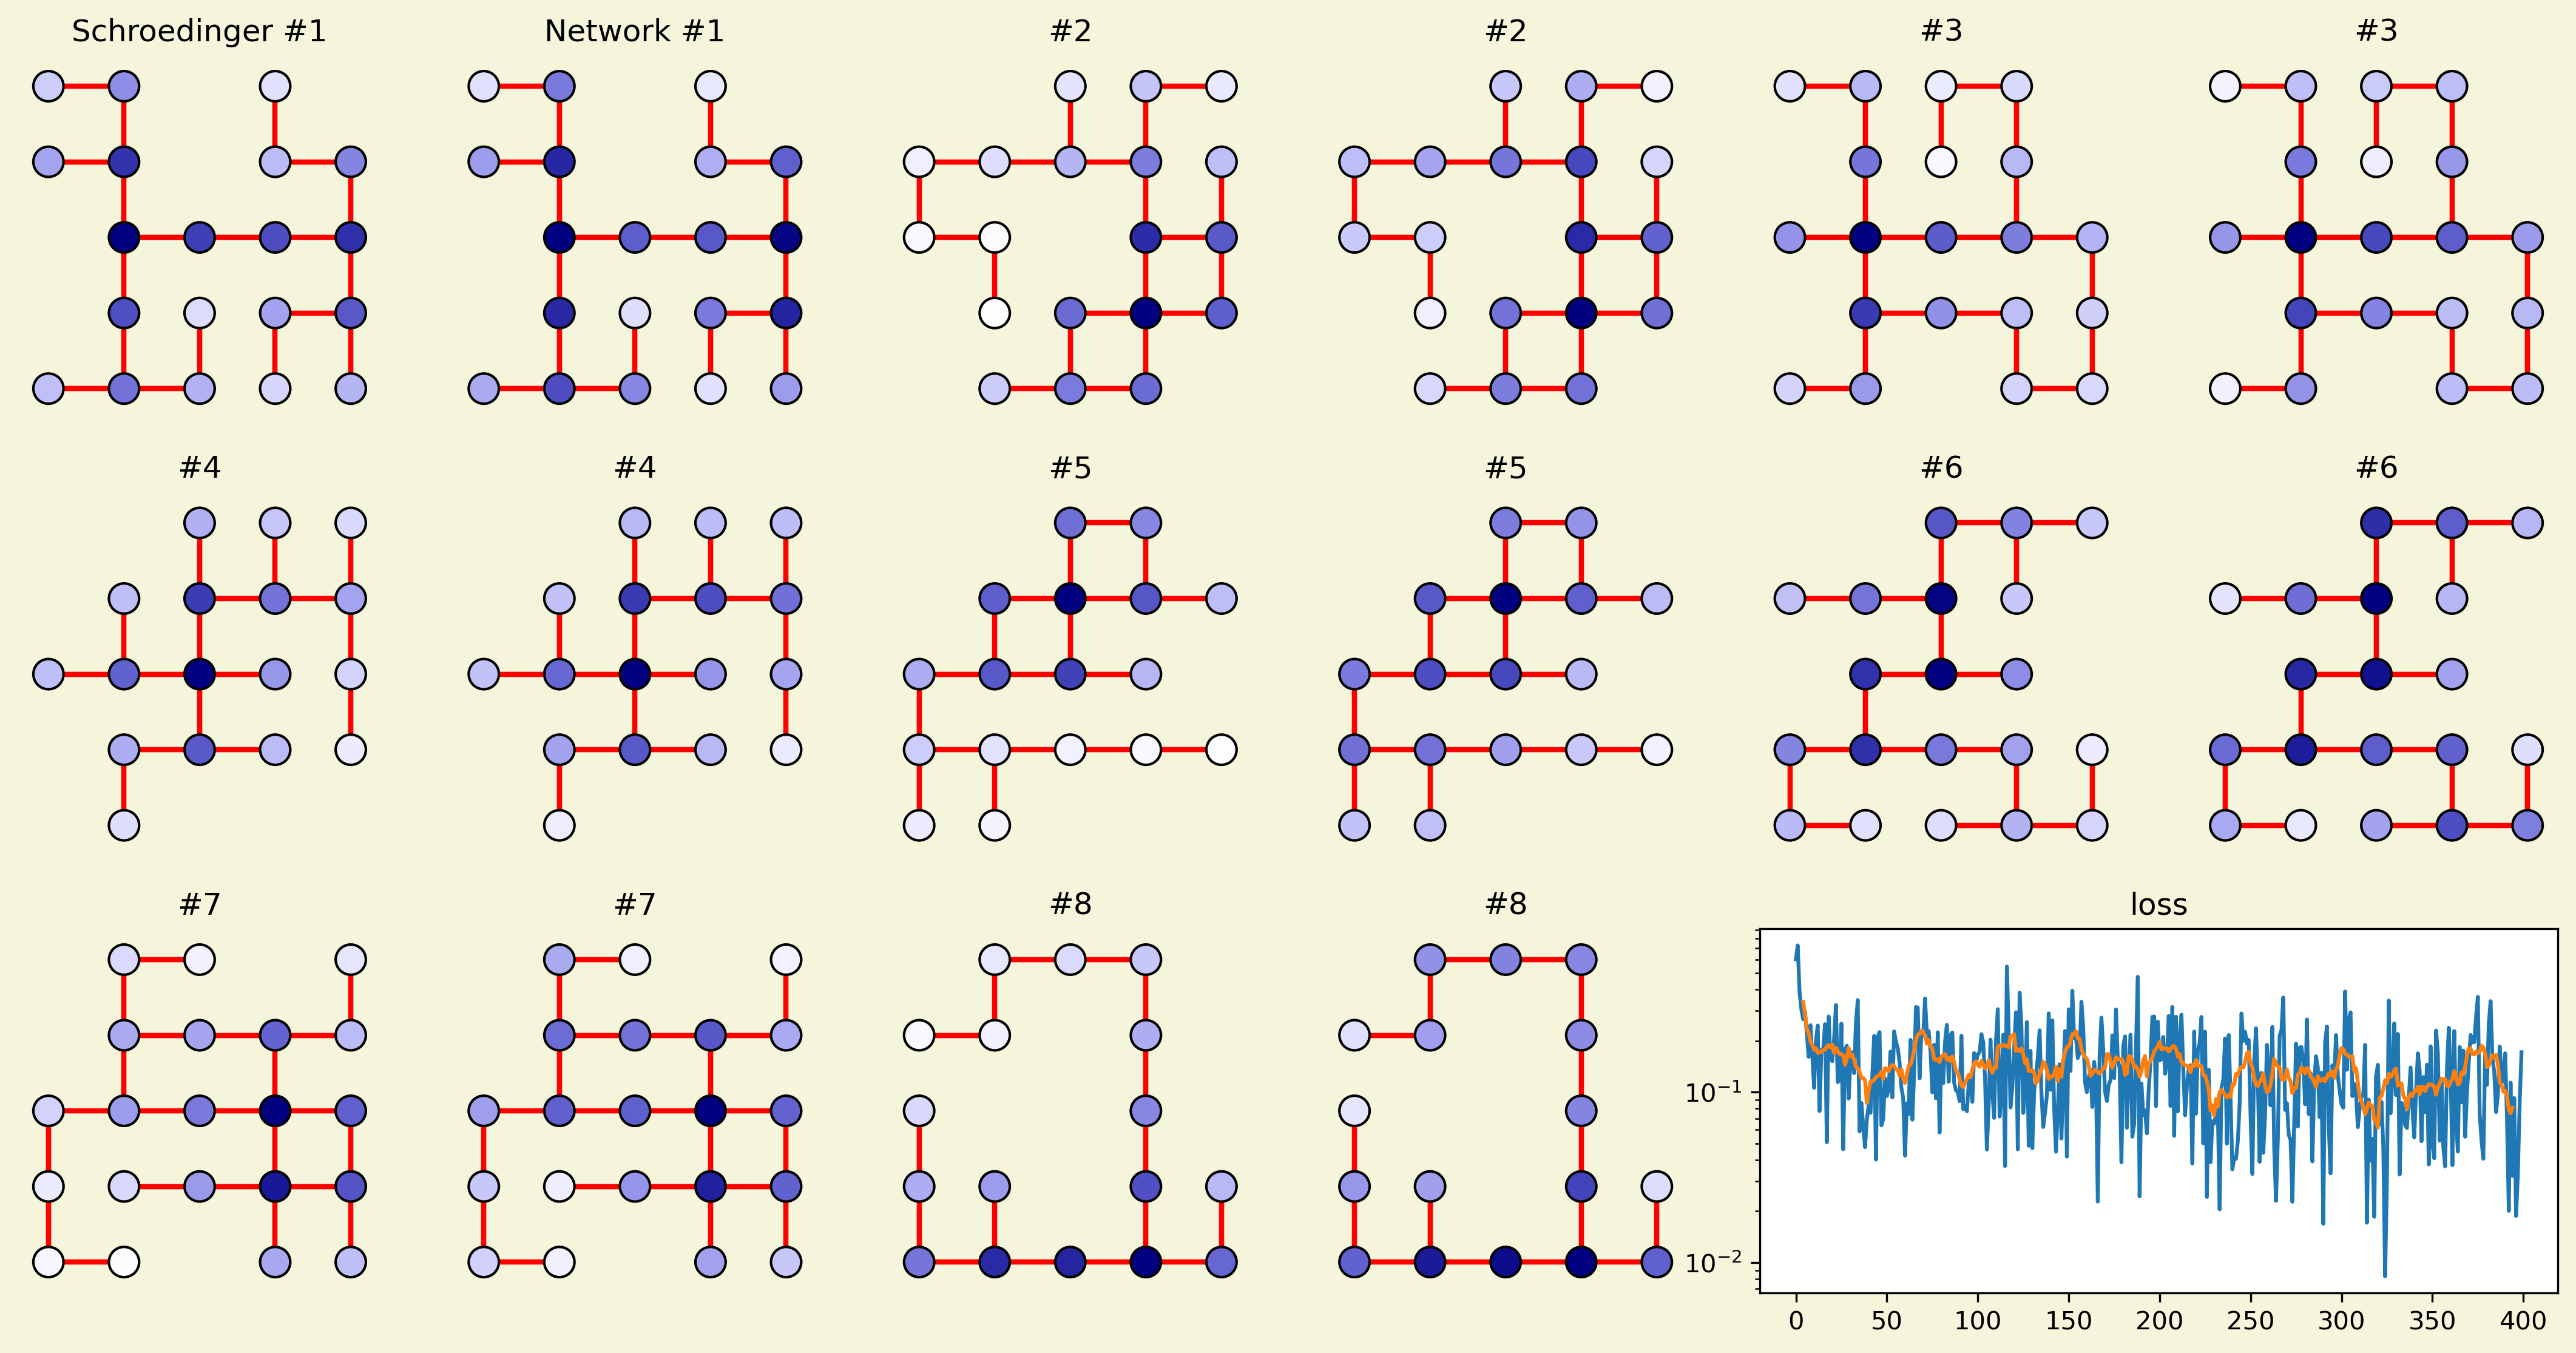

In [657]:
# create message and update networks

# number of dimensions of the node values in each layer (including input and output):
dim_nodes_layers=[1,3,3,3,3,3,1]
# shapes of message networks (hidden and output layer neuron numbers, and activation functions)
msg_nets_layers=[[(10,"relu"),(2,"linear")]]*6

# dimension of edge values
dim_edge_values=1

# now produce the list of message networks
message_networks=[create_message_network(dim_node_values=dim_nodes,
                            dim_edge_values=dim_edge_values, layers=layers) for dim_nodes,layers in
                 zip(dim_nodes_layers,msg_nets_layers)]

# shapes of update nets (output dimensions of each layer must match node value dimension
# of the next node layer, i.e. dim_nodes_layers[1] from above must match the output dim. of the
# first update net listed here)
update_nets_layers=[ [(11,"relu"),(3,"linear")] ]*5 + \
                    [ [(8,"relu"),(1,"linear")] ]
                   

# create all update networks
update_networks=[create_update_network(dim_message=msg_layers[-1][0],
                                      dim_node_values_input=dim_nodes,
                                      layers=update_layers) for dim_nodes,msg_layers,update_layers in
                zip(dim_nodes_layers,msg_nets_layers,update_nets_layers)]

# produce a graph NN from all these networks
graphNN=GraphNN(message_networks=message_networks,
            update_networks=update_networks,
            final_pooling_network=None,
            final_pooling_fn=None )

# list of losses for training
losses=[]

# prepare test samples
N=5
prob=0.4
test_samples=[get_sample(N=N,prob=prob) for _ in range(8)]

# prepare movie routines

def setup_figure():
    """
    Set up the figure for the animation.
    """
    fig=plt.figure(figsize=(18,9),dpi=300)
    mosaic="""
    012345
    6789AB
    CDEFGG
    """
    ax=fig.subplot_mosaic(mosaic)
    ax=[ax[key] for key in ax]
    return fig,ax

def anim_func(fig,ax,frame):
    """
    Will access N,prob,graphNN,test_samples, and add to losses !
    """
    # train
    graph,positions,Psi=get_sample(N=N,prob=prob)
    with tf.GradientTape() as tape:
        Psi_NN=graphNN.apply(graph)[:,0] # output was shape (num_nodes,1)
        loss=tf.reduce_sum((Psi_NN-Psi)**2)
    grads=tape.gradient(loss,graphNN.trainable_variables)
    graphNN.optimizer.apply_gradients(zip(grads,graphNN.trainable_variables))
    losses.append(loss.numpy())
    
    # plot
    for entry in ax:
        entry.clear()
    evaluate_and_plot_test_samples(graphNN,test_samples,N=N,ax=ax)
    ax[-1].semilogy(losses)
    if len(losses)>=10:
        nsmooth=10
        ax[-1].semilogy(np.arange(nsmooth-1,len(losses))-nsmooth//2,
                     np.convolve(losses, np.ones((nsmooth,))/nsmooth, mode='valid'))
        ax[-1].set_title("loss")

    ax[0].set_title("Schroedinger #1")
    ax[1].set_title("Network #1")

    for idx in range(1,8):
        text=f"#{idx+1}"
        ax[idx*2].set_title(text)
        ax[idx*2+1].set_title(text)

    ax[0].set_facecolor("white")
    ax[1].set_facecolor("white")

max_frames=400

save_movie_with_setup(setup_figure,anim_func, max_frames, "/tmp/GraphNN_bignet_movie.mp4", 
        fps=10, bitrate=2000,
        dpi_movie=300)

## Other things: other random graphs and tests etc.; not needed here, but possibly good for other tasks

In [19]:
def create_random_graph(num_nodes,num_neighbors_k, beta):
    """
    I think this implements the Watts-Strogatz random graphs,
    but I did not debug it. (there is still some bug with
    duplicate links...)
    """
    connections=[]
    for idx_i in range(num_nodes):
        for idx_j in range(idx_i+1,idx_i+num_neighbors_k//2+1):            
            if np.random.uniform()<beta:
                idx_j_new=(idx_i+np.random.randint(1,num_nodes)) % num_nodes
            else:
                idx_j_new=idx_j % num_nodes
            connections.append([idx_i,idx_j_new])
    return connections

def random_graph_with_random_values_and_edges(max_num_nodes,num_neighbors_k, beta, 
                                              dim_node_values, dim_edge_values,
                                             scale_node_values=1.0,
                                             scale_edge_values=1.0):
    """
    Create a random graph (a tuple of Graph type, with format (node_values,edge_values,receives_from);
    see GraphNN.apply).
    
    max_num_nodes: maximum number of nodes 
        (a random integer num with 1<=num<=max_num_nodes will be chosen for the actual
        number of nodes)
    num_neighbors_k: controls how many edges one gets. Needs to be even. Start with 2.
    beta: controls how random the graph is. Between 0 (not random) and 1 (fully random).
    
    dim_node_values: dimension of the node value vectors
    dim_edge_values: dimension of the edge value vectors
    
    The node and edge values are drawn from normal distributions, which
    can be multiplied by some scale (see keyword arguments).
    
    Returns a graph (named tuple Graph)
    """
    num_nodes=np.random.randint(max_num_nodes-1)+2
    connections=create_random_graph(num_nodes,num_neighbors_k=num_neighbors_k,beta=beta)
    receives_from,num_nodes,num_edges=produce_graph_receives_from(num_nodes,connections)
    return Graph(node_values=scale_node_values*np.random.randn(num_nodes,dim_node_values),
                edge_values=scale_edge_values*np.random.randn(num_edges,dim_edge_values),
                receives_from=receives_from)

def plot_graph(graph,node_values,edge_values,
               linewidth_scale=2.0,
               color_positive_edge="cornflowerblue",
               color_negative_edge="red",
               radius=0.1,ax=None):
    """
    Plot a graph, with nodes arranged on a circle.
    """
    if ax is None:
        ax=plt.gca()
    _,_,receives_from=graph
    num_nodes=len(node_values)
    idx=np.arange(num_nodes)
    angle=idx*2*np.pi/num_nodes
    x=np.cos(angle)
    y=np.sin(angle)
    max_edge_values=np.amax(np.abs(edge_values))
    for target_idx,links in enumerate(receives_from):
        for source_idx,edge in links:
            ax.plot([x[source_idx],x[target_idx]],[y[source_idx],y[target_idx]],
                    linewidth=linewidth_scale*np.abs(edge_values[edge])/max_edge_values,
                   color=color_positive_edge if edge_values[edge]>0 else color_negative_edge)
    max_value=np.amax(np.abs(node_values))
    for node_idx,value in enumerate(node_values):
        scaled_value=np.abs(value)/max_value
        ax.add_patch( plt.Circle((x[node_idx],y[node_idx]),radius,
                                 facecolor=(1.0-scaled_value,1.0-scaled_value,1.0-0.5*scaled_value**2) if value>0 else
                                         (1.0-0.5*scaled_value**2,1.0-scaled_value,1.0-scaled_value),
                               edgecolor='black', zorder=10) )
    ax.set_xlim(-1.2,1.2)
    ax.set_ylim(-1.2,1.2)
    ax.axis('off')
    ax.set_aspect('equal')

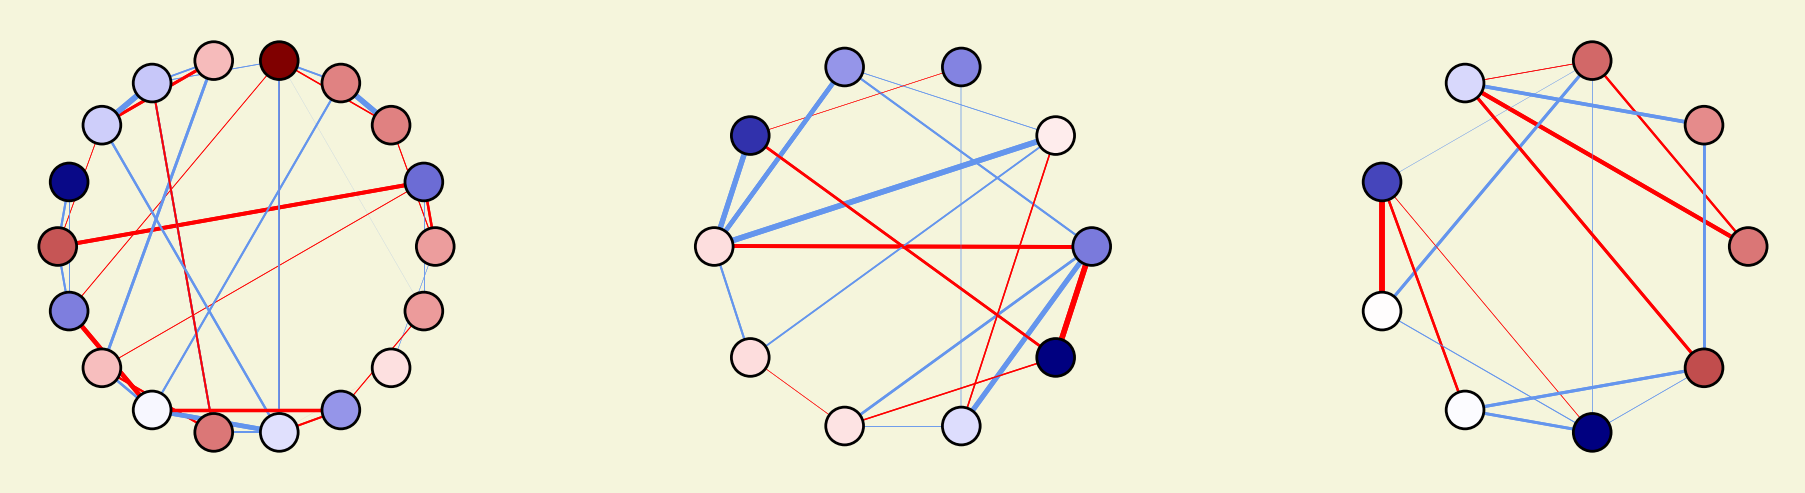

In [20]:
fig,ax=plt.subplots(ncols=3,figsize=(12,3),dpi=200)
for ax_entry in ax:
    random_graph=random_graph_with_random_values_and_edges(max_num_nodes=20,
                                 num_neighbors_k=4,
                                beta=0.5,
                                dim_node_values=1,
                                dim_edge_values=1)
    plot_graph(random_graph, node_values=random_graph.node_values[:,0], 
               edge_values=random_graph.edge_values[:,0],ax=ax_entry)
plt.show()

In [ ]:
for _ in range(100):
    conn=create_random_graph(num_nodes=5,num_neighbors_k=4,beta=0.5)
    check_graph(conn)

Duplicate link: old 4,[2, 3], new 5 [2, 3]
Duplicate link: old 5,[2, 3], new 4 [2, 3]
Duplicate link: old 8,[4, 0], new 9 [4, 0]
Duplicate link: old 9,[4, 0], new 8 [4, 0]
Duplicate link: old 2,[1, 2], new 3 [1, 2]
Duplicate link: old 3,[1, 2], new 2 [1, 2]
Duplicate link: old 6,[3, 0], new 7 [3, 0]
Duplicate link: old 7,[3, 0], new 6 [3, 0]
Duplicate link: old 8,[4, 2], new 9 [4, 2]
Duplicate link: old 9,[4, 2], new 8 [4, 2]
Duplicate link: old 4,[2, 4], new 5 [2, 4]
Duplicate link: old 5,[2, 4], new 4 [2, 4]
Duplicate link: old 6,[3, 4], new 7 [3, 4]
Duplicate link: old 7,[3, 4], new 6 [3, 4]
Duplicate link: old 0,[0, 2], new 1 [0, 2]
Duplicate link: old 1,[0, 2], new 0 [0, 2]
Duplicate link: old 6,[3, 0], new 7 [3, 0]
Duplicate link: old 7,[3, 0], new 6 [3, 0]
Duplicate link: old 2,[1, 3], new 3 [1, 3]
Duplicate link: old 3,[1, 3], new 2 [1, 3]
Duplicate link: old 4,[2, 4], new 5 [2, 4]
Duplicate link: old 5,[2, 4], new 4 [2, 4]
Duplicate link: old 2,[1, 2], new 3 [1, 2]
Duplicate l

### A few simple tests

In [21]:
# Test message network:
msg_net=create_message_network(dim_node_values=3,
                               dim_edge_values=4,layers=[(10,"relu"),(5,"linear")] )


In [22]:
msg_net.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
tf.concat_8 (TFOpLambda)        (None, 10)           0           input_21[0][0]                   
                                                                 input_22[0][0]             

In [23]:
# Test update network
update_net=create_update_network(dim_message=5,dim_node_values_input=3,
                                layers=[(11,"tanh"),(7,"linear")])

In [24]:
# a mini graph, with nodes 1,2,3 and node 1 receiving messages from 2 and 3
node1=np.random.randn(1,3)
node2=np.random.randn(1,3)
node3=np.random.randn(1,3)
edge12=np.random.randn(1,4)
edge13=np.random.randn(1,4)

# produce messages from 2 and 3 towards 1
msg12=msg_net([node1,node2,edge12])
msg13=msg_net([node1,node3,edge13])

# sum them up
message_for_1=msg12 + msg13

# now calculate the true update for node 1
new_node1=update_net([node1,message_for_1])


# now pretend we have done this for all nodes, and want
# to calculate the update in parallel:
nodes_all=tf.concat([node1,node2,node3],axis=0)
# here we cheat and reuse the same message for all...
messages_all=tf.concat([message_for_1,message_for_1,message_for_1],axis=0)

new_nodes_all=update_net([nodes_all,messages_all])

new_nodes_separate=list(new_nodes_all) # turn it back into a list of nodes

In [25]:
new_nodes_separate

[<tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([ 0.46006492,  0.5243808 , -0.2009127 ,  0.74161863, -0.1126435 ,
         0.01343989,  0.47415087], dtype=float32)>,
 <tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([-0.12559551, -0.5863122 ,  0.59211683,  1.5827368 ,  0.5009074 ,
         0.8609033 ,  1.1017776 ], dtype=float32)>,
 <tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([ 5.6274939e-01,  4.2114583e-01, -2.7031487e-01,  6.0217822e-01,
         4.9793720e-04,  2.2495078e-01,  7.2200656e-01], dtype=float32)>]

In [26]:
graph_is_connected(4,[[1,0],[1,2],[1,2],[3,1]])

True